In [1]:
import numpy as np
import matplotlib.pyplot as plt

orbit plane is (x,y)

position of jet source as a function of ejection time $t_e$

$x(t_e) = r_0 \cos (\omega_B t_e)$

$y(t_e) = r_0 \sin (\omega_B t_e)$

precessing jet has initial velocity  vector

${\bf v}_j = v_j ( \sin \beta  \cos (\Omega_p t_e - \phi_0),
\sin \beta  \sin (\Omega_p t_e - \phi_0),  \cos \beta )$

together the initial velocity is 

$v_x(t_e)  = -r_0 \omega_B \sin (\omega_B t_e) + v_j  \sin \beta  \cos (\Omega_p t_e - \phi_0)$

$v_y(t_e)  = r_0 \omega_B \cos (\omega_B t_e) + v_j  \sin \beta  \sin (\Omega_p t_e - \phi_0)$

$v_z(t_e)  = v_j \cos \beta$

integrate

$x(t,t_e) = v_x(t_e) (t-t_e) + r_0 \cos (\omega_B t_e)$

$y(t,t_e) = v_y(t_e)  (t-t_e) + r_0 \sin (\omega_B t_e)$

$z(t,t_e) = v_z(t_e)  (t-t_e)$

$r_0$ is position of jet source from center of mass of binary.

$\beta$ is half opening angle of jet angle (angle between jet and orbit normal).

$\Omega_p t_e - \phi_0$ is jet precession angle (jet axis projected onto orbit plane).

$v_j$ is jet velocity. 

$\omega_B$ is mean motion of binary orbit. 

$t_e$ is ejection time for jet blob. 

$x,y,z$ are position of blob at current time $t$.

$\Omega_p$ is jet precession rate.

Choose $x$ axis from orbital plane in plane of sky and $z$ axis in plane of sky.
This means $y$ axis (in orbital plane) is along line of sight. 

Sky coordinates $x_s, y_s, z_s$ where $y_s$ is along line of sight.

We want to rotate, so that we can tilt the orbit plane via inclination $i$. 
We rotate in $yz$ plane,   keeping $x$ untouched.

$\begin{pmatrix} x_s \\ y_s \\ z_s \end{pmatrix} = 
\begin{pmatrix} 1 & 0 & 0 \\ 0 & \cos i & \sin i \\   0 & -\sin i & \cos i \end{pmatrix} 
\begin{pmatrix} x \\ y \\ z \end{pmatrix}  = 
\begin{pmatrix} x \\  y \cos iy + z\sin i  \\ -y\sin i  + z\cos i  \end{pmatrix}
$

In [2]:
# set te = array of ejection times, oldest ejection was at te=0
te = np.linspace(0,3e-3,200)  #in Myrs
t = max(te)   # current time is the maximum of possible ejection times
AUtopc = 1./206265 #1.5e13/3.0e18  # from AU to pc
#pc = 3.0e18 # cm
#G = 6.674e-8 # g m^3/s^2
G = 4.30091E-3 #  pc Msol^−1 (km/s)2  # gravitational constant for Galaxy

# set params for model
m1 =  1.0 # masses msol, jet source
m2 =  1.0  # mass of secondary msol
a_B_AU = 20.0  # AU binary semi-major axis
beta_deg  = 30.0/2 # half opening angle for jet in degrees 
phi0 = -np.pi/2  # initial precession phase in radians
vj = 350.0  # jet velocity in km/s
incl = 0.0  # inclination tilt of orbital z axis out of plane of sky in radians
Omega_p_fac = 20 # ratio of periods precession to orbital 
PA_deg = 0.0 # position angle on sky to rotate from N, in degrees

#calculate a bunch of arrays
def mkarrs(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg):
    a_B=  a_B_AU*AUtopc #binary semi-major axis, convert from AU to pc
    r0 = m2/(m1+m2) * a_B  # in pc - distance of m1 from Center of mass of binary
    # units pc
    # velocity of binary 
    v_B = np.sqrt(G*(m1+m2)/a_B)  # velocity of binary orbit in km/s which is pc/Myr
    # note: this is not w.r.t center of mass 
    omega_B = v_B/a_B  # is in Myr-1, angular rotation rate of binary (mean motion)
    beta = beta_deg*np.pi/180  # in radians, opening angle of jet
    # note that r0*omega_B < v_B
    Omega_p = omega_B/Omega_p_fac  # units Myr-1, this is the precession rate 

    # compute velocities and positions
    # coordinate system xy orbital plane, z perpendicular to it
    
    #initial ejection velocity 
    vxarr = -r0*omega_B*np.cos(omega_B*te)+ vj*np.sin(beta)*np.cos(Omega_p*te - phi0)
    vyarr =  r0*omega_B*np.sin(omega_B*te)+ vj*np.sin(beta)*np.sin(Omega_p*te - phi0)
    vzarr =  vj*np.cos(beta)
    # integrated positions later on
    xarr = vxarr*(t-te) + r0*np.cos(omega_B*te)
    yarr = vyarr*(t-te) + r0*np.sin(omega_B*te)
    zarr = vzarr*(t-te)

    # rotate x,y,z to xs,ys,zs to on sky taking into account orbit inclination
    xsarr = xarr
    ysarr =  np.cos(incl)*yarr + np.sin(incl)*zarr
    zsarr = -np.sin(incl)*yarr + np.cos(incl)*zarr

    # also rotate the velocities 
    vxsarr = vxarr
    vysarr =  np.cos(incl)*vyarr + np.sin(incl)*vzarr
    vzsarr = -np.sin(incl)*vyarr + np.cos(incl)*vzarr
    
    # rotate by position angle on sky from N
    PA = PA_deg*np.pi/180.
    
    xsarr_PA = np.cos(PA)*xsarr - np.sin(PA)*zsarr
    zsarr_PA = np.sin(PA)*xsarr + np.cos(PA)*zsarr
    
    # return all these arrays
    return xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA

In [3]:

ddin_deg = 5.0  # spacing of inclinations in degrees
#plot a series of different inclinations
def plt_stuff(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,ddin_deg):
    
    # show jet blobs on sky
    fig,axarr = plt.subplots(1,5,figsize=(6,4),sharex=True,sharey=True,dpi=100)
    plt.subplots_adjust(hspace=0,wspace=0)
    for i in range(0,5):
        incl = i*ddin_deg*np.pi/180 # inclination
        # compute arrays
        xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = \
            mkarrs(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg)
        # plot positions 
        axarr[i].plot(xsarr_PA,zsarr_PA,'-')
        axarr[i].set_aspect('equal')
    axarr[0].set_ylabel('(pc)')
    axarr[0].set_xlabel('(pc)')
    
    # show velocities proper-motions and radial velocities as a function of projected distance
    fig,axarr = plt.subplots(5,1,figsize=(6,4),sharex=True,sharey=True)
    plt.subplots_adjust(hspace=0,wspace=0)

    for i in range(0,5):
        incl = i*ddin_deg*np.pi/180
        xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = \
            mkarrs(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg)
    
        vpp = np.sqrt(vxsarr**2 + vzsarr**2)  # velocity on sky plane
        dsky = np.sqrt(xsarr**2  + zsarr**2)   # distance on sky from source
        axarr[i].plot(dsky,vpp,'b-')  # plot proper motion
        axarr[i].plot(dsky,vysarr,'g-')  #  plot radial velocity
        #axarr[i].set_aspect('equal')
    axarr[4].set_xlabel('d (pc)')
    axarr[0].set_ylabel(r'$v_{pp}$ (km/s)')

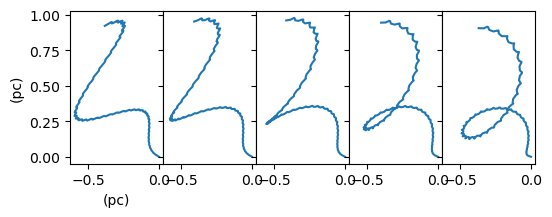

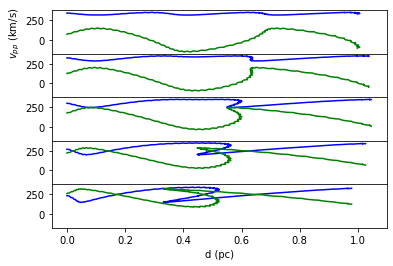

In [4]:
# chose parms 
m1 =  1.0 # masses msol, jet source
m2 =  1.0 # binary companion, msol
a_B_AU = 20.0  # binary semi-major axis in AU
beta_deg  = 25.0 # half opening angle for jet in degrees 
phi0 = 0.5*np.pi/2  # initial precession phase in radians
vj = 350.0  # jet velocity in km/s
#incl = 0.0  # inclination tilt of orbital z axis out of plane of sky in radians
Omega_p_fac = 30 # ratio of periods precession to orbital 
PA_deg = 40.0 # position angle on sky to rotate from N, in degrees

ddin_deg = 10  # in degrees, spacing for inclination changes 
plt_stuff(m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,ddin_deg)



In [5]:
# looks like we cannot get proper motion to drop?
# this means that velocity drop is due to slowing down?
#  if so happy feedback result
# what about direction of precession, compared to orbit
# is direction of binary orbit known?

In [6]:
# along knots maybe extinction increases which puts at distance further away from us?


In [7]:
# Should we try a model where we slow down the jet?


Suppose we allow damping 

The initial velocity is still

$v_x(t_e)  = -r_0 \omega_B \sin (\omega_B t_e) + v_j  \sin \beta  \cos (\Omega_p t_e - \phi_0)$

$v_y(t_e)  = r_0 \omega_B \cos (\omega_B t_e) + v_j  \sin \beta  \sin (\Omega_p t_e - \phi_0)$

$v_z(t_e)  = v_j \cos \beta$

However we let the velocity amplitude drop with travel time  
${\bf v}(t,t_e) = {\bf v}(t_e) e^{-\alpha (t-t_e)} $

integrate

${\bf x} = {\bf x}_0 + \frac{ {\bf v}(t_e)}{\alpha} (1 -  e^{-\alpha (t-t_e)} ) $

$x(t,t_e) = v_x(t_e) \frac{1}{\alpha}(1 - e^{-\alpha (t-t_e)}) + r_0 \cos (\omega_B t_e)$

$y(t,t_e) = v_y(t_e)  \frac{1}{\alpha}(1 - e^{-\alpha (t-t_e)}) + r_0 \sin (\omega_B t_e)$

$z(t,t_e) = v_z(t_e)  \frac{1}{\alpha}(1 - e^{-\alpha (t-t_e)}) $


In [8]:
#Make a bunch of arrays
def mkarrs_slow(vobs, m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha):
#     te = np.linspace(tlower,tupper,200)  #in Myrs
#     t = np.max(te) # current time is the maximum of possible ejection times
    
    a_B=  a_B_AU*AUtopc #binary semi-major axis, convert from AU to pc
    r0 = m2/(m1+m2) * a_B  # in pc - distance of m1 from Center of mass of binary
    # units pc
    # velocity of binary 
    v_B = np.sqrt(G*(m1+m2)/a_B)  # velocity of binary orbit in km/s which is pc/Myr
    # note: this is not w.r.t center of mass 
    omega_B = v_B/a_B  # is in Myr-1, angular rotation rate of binary (mean motion)
    beta = beta_deg*np.pi/180  # in radians, opening angle of jet
    # note that r0*omega_B < v_B
    Omega_p = omega_B/Omega_p_fac  # units Myr-1, this is the precession rate 

    # compute velocities and positions
    # coordinate system xy orbital plane, z perpendicular to it
    #initial values
    vxarr_e = -r0*omega_B*np.cos(omega_B*te)+ vj*np.sin(beta)*np.cos(Omega_p*te - phi0)
    vyarr_e =  r0*omega_B*np.sin(omega_B*te)+ vj*np.sin(beta)*np.sin(Omega_p*te - phi0)
    vzarr_e =  vj*np.cos(beta)
    
    # instantaneous values for velocity 
    expfac = np.exp(-(t-te)*alpha)
    vxarr = vxarr_e*expfac
    vyarr = vyarr_e*expfac
    vzarr = vzarr_e*expfac
    
    # integrated positions
    slow_fac = (1.  - np.exp(-(t-te)*alpha))/alpha
    xarr = vxarr_e*slow_fac + r0*np.cos(omega_B*te)
    yarr = vyarr_e*slow_fac + r0*np.sin(omega_B*te)
    zarr = vzarr_e*slow_fac

    # rotate x,y,z to xs,ys,zs
    xsarr = xarr
    ysarr =  np.cos(incl)*yarr + np.sin(incl)*zarr
    zsarr = -np.sin(incl)*yarr + np.cos(incl)*zarr

    # also rotate velocities 
    vxsarr = vxarr
    vysarr =  np.cos(incl)*vyarr + np.sin(incl)*vzarr
    vzsarr = -np.sin(incl)*vyarr + np.cos(incl)*vzarr
    
    # rotate by position angle on sky from N
    PA = PA_deg*np.pi/180.
    
    xsarr_PA = np.cos(PA)*xsarr - np.sin(PA)*zsarr
    zsarr_PA = np.sin(PA)*xsarr + np.cos(PA)*zsarr
    
    return xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA

#plot different inclinations
def plt_stuff_slow(vobs, m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha,ddin_deg):
    
    # show jet blobs on sky
    fig,axarr = plt.subplots(1,5,figsize=(6,4),sharex=True,sharey=True,dpi=300)
    plt.subplots_adjust(hspace=0,wspace=0)
    for i in range(0,5):
        incl = i*ddin_deg*np.pi/180
        xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = \
            mkarrs_slow(vobs, m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha)
        axarr[i].plot(xsarr_PA,zsarr_PA,'-')
        axarr[i].set_aspect('equal')
    axarr[0].set_ylabel('(pc)')
    axarr[0].set_xlabel('(pc)')
    
    # show velocities propermotions and radial ones as a function of projected distance
    fig,axarr = plt.subplots(5,1,figsize=(6,4),sharex=True,sharey=True)
    plt.subplots_adjust(hspace=0,wspace=0)

    for i in range(0,5):
        incl = i*ddin_deg*np.pi/180
        xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = \
            mkarrs_slow(vobs, m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha)
    
        vpp = np.sqrt(vxsarr**2 + vzsarr**2)  # velocity on sky plane
        dsky = np.sqrt(xsarr**2  + zsarr**2)   # distance on sky from source
        axarr[i].plot(dsky,vpp,'b-')  #proper motion
        axarr[i].plot(dsky,vysarr,'g-')  # radial velocity
        #axarr[i].set_aspect('equal')
    axarr[4].set_xlabel('d (pc)')
    axarr[0].set_ylabel(r'$v_{pp}$ (km/s)')

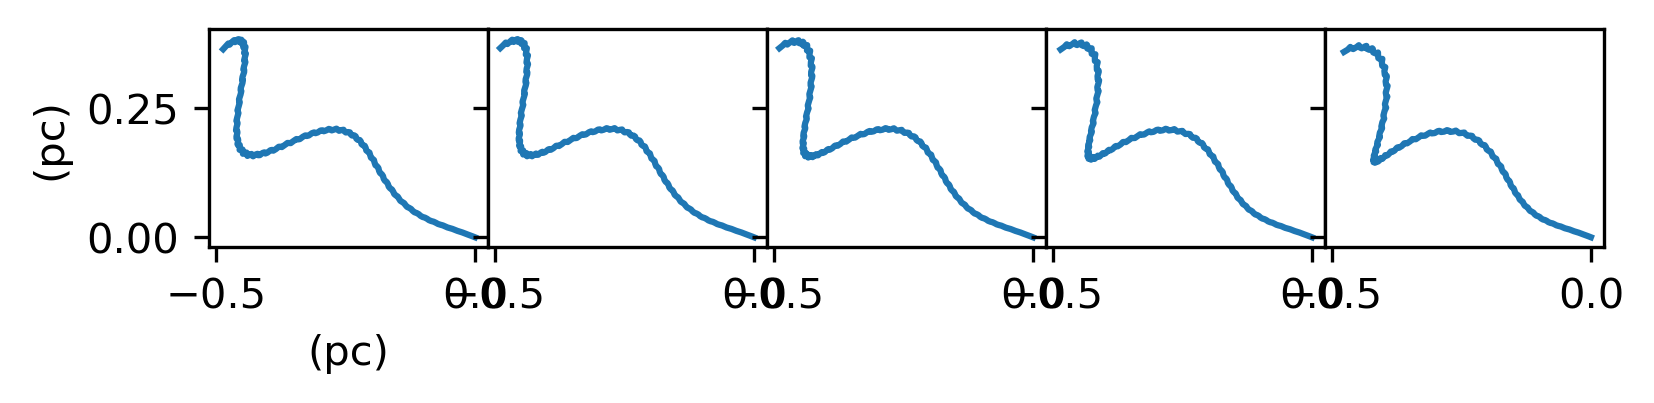

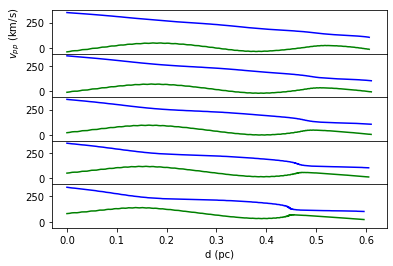

In [9]:
# chose parms again!
m1 =  2.0 # masses msol, jet source
m2 =  0.5 #  companion mass msol
a_B_AU = 20.0  # AU
beta_deg  = 10.0 # half opening angle for jet in degrees 
phi0 = 0.5*np.pi/2  # initial precession phase in radians
vj = 350.0  # jet velocity in km/s
#incl = 0.0  # inclination tilt of orbital z axis out of plane of sky in radians
Omega_p_fac = 30 # ratio of periods precession to orbital 
PA_deg = 60.0 # position angle on sky to rotate from N, in degrees
alpha=400. # how fast to slow velocity down, units Myr-1

ddin_deg = 5.0  # in degrees, how to step in inclination 

plt_stuff_slow(vj, m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha,ddin_deg)

# Load and try to model data...starting with initial constraints on speed and shape parameters

In [144]:
#purpose is to generate images in the steps below, first collecting some files
'''
Paths and file needs:
*imglams and spitzer_conversions are excel files, right now I have it so you need to put it as same directory as your code (but could later maybe just give it a path to go to - would be smarter)
*paths to images and data in general
'''

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


#here we try to grab a 1.64 mic fits image with minimal 
# path = '../continuum_subtract/nocont*164*.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
path = '../scaling_for_motions/f160_diff_epoch2_1.fits'
im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
print(im_names_n2071)

hdu_list = [fits.open(i) for i in im_names_n2071]

#initializing some lists to be used
hdu_data_list = []
hdu_header_list = []

count = 0
for hdu_data in hdu_list:   
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    
    #needed because the second image in this list is negative...
    if count == 1:
        sign = -1
    else:
        sign = 1
    hdu_data_list.append(sign * hdu_data[0].data) # * hdu_list[0].header['PHOTFLAM'] * hdu_list[0].header['PHOTBW'])
    hdu_header_list.append(hdu_data[0].header)
    
    count+=1
    
#trying this with cutout2d
# https://docs.astropy.org/en/stable/nddata/utils.html#cutout-images
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord, FK5, ICRS
from photutils.aperture import EllipticalAperture

#trying it by hand

#known pixel size
hst_pixsize = 0.12825 #arcsec

# f = open('moving_blobs.reg', 'r')
# f1 = open('precession_inflections.reg', 'r')
# f1 = open('epoch2_361c_byhand_ellipses.reg', 'r')
f1 = open('epoch2_centroids.reg', 'r')
file1_output = []

#looping through file 
for line in f1:
    file1_output.append(line)
f1.close()

#fix file contents
#contents are ra, dec, width, height, rotation
# file1_output = [i[8:-2] for i in file1_output[3:]]
file1_output = sorted([i[6:31] for i in file1_output[3:]])

#next step is for image, loop through all regions and make a list of region properties
ra_pix_list = []
dec_pix_list = []
rad_a_list = []
rad_b_list = []
rotation_list = []

#coordinate details
split_params1 = [i.split(',') for i in file1_output[:-1]]
ra_hms_list = [ra1[0].split(':')[0]+'h' + ra1[0].split(':')[1]+'m' + ra1[0].split(':')[2]+'s' for ra1 in split_params1]
dec_dms_list = [dec1[1].split(':')[0]+'d' + dec1[1].split(':')[1]+'m' + dec1[1].split(':')[2]+'s' for dec1 in split_params1]
pos_list = [SkyCoord(ra+' '+dec, frame=FK5, unit=(u.hourangle, u.deg)) for ra, dec in zip(ra_hms_list, dec_dms_list)]

#this isn't working for some reason...skycoord_to_pixel doesn't seem to like units? not sure
ra_pix_list = np.array([skycoord_to_pixel(i, wcs=WCS(hdu_header_list[0]))[0] for i in pos_list])
dec_pix_list = np.array([skycoord_to_pixel(i, wcs=WCS(hdu_header_list[0]))[1] for i in pos_list])

#converting and  comparing to 361c
hops_361c_coord = SkyCoord('5h47m4.631s', '0d21m47.82s', frame=FK5)
hops_361c_pix = skycoord_to_pixel(hops_361c_coord, wcs=WCS(hdu_header_list[0]))

ra_centroid_pc_list = np.abs(ra_pix_list - hops_361c_pix[0]) * hst_pixsize * 430.1 / 206265
dec_centroid_pc_list = np.abs(dec_pix_list - hops_361c_pix[1]) * hst_pixsize * 430.1 / 206265
print(ra_centroid_pc_list, dec_centroid_pc_list)

centroid_source_sep = np.sqrt(ra_centroid_pc_list**2 + dec_centroid_pc_list**2)
print(centroid_source_sep)

#aperture size details
# rad_a_list = [[1./hst_pixsize * float(rad_a1[2][:-1])] for rad_a1 in split_params1]
# rad_b_list = [[1./hst_pixsize * float(rad_b1[2][:-1])] for rad_b1 in split_params1]
# rotation_list = [[float(rot1[4])] for rot1 in split_params1]

3.8.13
['../scaling_for_motions/f160_diff_epoch2_1.fits']
[0.01057876 0.01314039 0.02104683 0.02821537 0.03960263 0.03472293
 0.05725504 0.06464166 0.08187447 0.08526195 0.10863106] [0.01265423 0.01508176 0.02824896 0.03121888 0.05072994 0.03989874
 0.06645084 0.06775898 0.07544019 0.07973272 0.07953171]
[0.01649363 0.02000323 0.03522744 0.04207999 0.06435756 0.05289226
 0.08771461 0.09364734 0.11133127 0.11673434 0.13463284]


In [11]:
#initial parameters and setup
m1 =  1.0 # masses msol, jet source
m2 =  1.0 #  companion mass msol
a_B_AU = 15.0  # AU

a_B=  a_B_AU*AUtopc #binary semi-major axis, convert from AU to pc
r0 = m2/(m1+m2) * a_B  # in pc - distance of m1 from Center of mass of binary
# units pc
# velocity of binary 
v_B = np.sqrt(G*(m1+m2)/a_B)  # velocity of binary orbit in km/s which is pc/Myr
# note: this is not w.r.t center of mass 
omega_B = v_B/a_B  # is in Myr-1, angular rotation rate of binary (mean motion)
# note that r0*omega_B < v_B


In [46]:
from scipy.optimize import curve_fit, minimize
vobs = np.array([407.63980695, 317.21726397, \
                 np.mean([227.49041226, 205.42416833, 195.30909916]), \
                 np.mean([187.11332797, 172.77048953]), \
                 145.2505226, \
                 np.mean([122.81817916, 118.97480194])])

#observed shape on sky, needs to be setup before function...
ra_pc_list = np.array([0.40378838, 0.43791952, \
                np.mean([0.46161887, 0.46515381, 0.47080677]), \
                   np.mean([0.48958144, 0.49457684]), 
                    0.5166475 , 
                     np.mean([0.56515751, 0.57174669])
                      ])
#np.array(ra_pix_list) * hst_pixsize * 430.1 / 206265
dec_pc_list = np.array([0.19297749, 0.16577757, \
                np.mean([0.1565024 , 0.15732436, 0.15776662]), \
                   np.mean([0.15622932, 0.15334822]), 
                    0.16142637, 
                     np.mean([0.18417474, 0.18925407])
                       ])
# np.array(dec_pix_list) * hst_pixsize * 430.1 / 206265

#distances to help with fit
knot_source_dist = np.array([0.01820776, 0.06173051, \
                            np.mean([0.08657498, 0.08917799, 0.09389317,]), \
                           np.mean([0.11140937, 0.11715022, ]), \
                            0.13485113, \
                            np.mean([0.17794939, 0.18407689])])

      fun: 0.02453955359939764
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.02258218e-06, -2.10144402e-06,  4.80171760e-06,  9.39283374e-06,
        1.13000472e-07, -3.43474976e-06,  8.66459682e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1592
      nit: 164
     njev: 199
   status: 0
  success: True
        x: array([2.90779485e-02, 4.72877206e-01, 1.18500622e+02, 1.07175917e-01,
       2.99106979e+07, 4.52906200e+02, 4.29268527e-01])


C:\Users\arubi\AppData\Local\Temp\ipykernel_24856\3334885184.py:25: RuntimeWarning: invalid value encountered in divide
  slow_fac = (1.  - np.exp(-(t-te)*alpha))/alpha


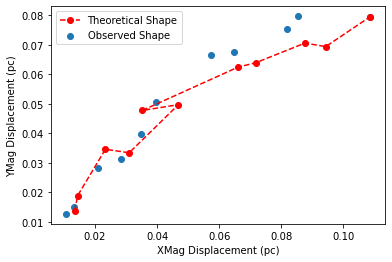

In [267]:

def shape_pc_fit(vobs, incl, phi0, PA_deg, beta, Omega_p, vj, alpha):
    #finding times assuming vj ~ 480 km/s and v = d/t or t = d/v
    te = centroid_source_sep / (vj * 1.022 )
    t = np.max(te)
    
    # compute velocities and positions
    # coordinate system xy orbital plane, z perpendicular to it
    #initial values
    vxarr_e = -r0*omega_B*np.cos(omega_B*te)+ vj*np.sin(beta)*np.cos(Omega_p*te - phi0)
    vyarr_e =  r0*omega_B*np.sin(omega_B*te)+ vj*np.sin(beta)*np.sin(Omega_p*te - phi0)
    vzarr_e =  vj*np.cos(beta)

    # instantaneous values for velocity 
    expfac = np.exp(-(t-te)*alpha)
    vxarr = vxarr_e*expfac
    vyarr = vyarr_e*expfac
    vzarr = vzarr_e*expfac

    # also rotate velocities 
    vxsarr = vxarr
    vysarr =  np.cos(incl)*vyarr + np.sin(incl)*vzarr
    vzsarr = -np.sin(incl)*vyarr + np.cos(incl)*vzarr
    
    # integrated positions
    slow_fac = (1.  - np.exp(-(t-te)*alpha))/alpha
    xarr = vxarr_e*slow_fac + r0*np.cos(omega_B*te)
    yarr = vyarr_e*slow_fac + r0*np.sin(omega_B*te)
    zarr = vzarr_e*slow_fac

    # rotate x,y,z to xs,ys,zs
    xsarr = xarr
    ysarr =  np.cos(incl)*yarr + np.sin(incl)*zarr
    zsarr = -np.sin(incl)*yarr + np.cos(incl)*zarr

    # rotate by position angle on sky from N, converting to pixel coordinates
    PA = PA_deg*np.pi/180.

    xsarr_PA = np.cos(PA)*xsarr - np.sin(PA)*zsarr + ra_centroid_pc_list[-1]
    zsarr_PA = np.sin(PA)*xsarr + np.cos(PA)*zsarr + dec_centroid_pc_list[-1]
#     xsarr_PA = (np.cos(PA)*xsarr - np.sin(PA)*zsarr ) * 206265 / 430.1 / hst_pixsize 
#     zsarr_PA = (np.sin(PA)*xsarr + np.cos(PA)*zsarr ) * 206265 / 430.1 / hst_pixsize 

    return xsarr_PA, zsarr_PA
#     return np.sqrt(xsarr_PA**2. + zsarr_PA**2.)


def shape_min_tester(params_precess, vobs):
    xsarr_PA, zsarr_PA = shape_pc_fit(vobs, *params_precess)
    return np.sqrt(np.sum((xsarr_PA-ra_centroid_pc_list)**2 + (zsarr_PA-dec_centroid_pc_list)**2))
#     return (np.sum(np.sqrt(xsarr_PA**2.+zsarr_PA**2.**2) - np.sqrt(ra_pc_list**2. + dec_pc_list**2.)))**2 / 1e-22

#looping through parameter space of interest (te, alpha)
vj = 448 #484. #km/s, note that to pc/Myr this is *1.022...
# te = knot_source_dist / vj * 3.086e13/977914 / 1e6 #pc / (km/s) means *secs/yrs convert to Myr
alpha = 300

#applying minimization scheme
incl = 45 * np.pi/180 # inclination tilt of orbital z axis out of plane of sky in radians
phi0 = 50*np.pi/180  # initial precession phase in radians 
PA_deg = 0 # position angle on sky to rotate from N, in degrees
beta_deg  = 15 #17.0 # half opening angle for jet in degrees 
beta = beta_deg*np.pi/180  # in radians, opening angle of jet
Omega_p_fac = 75 # ratio of periods precession to orbital 
Omega_p = 2.99107012e+07 #omega_B/Omega_p_fac  # units Myr-1, this is the precession rate  7500 #

#quicker checks to see if fit successful
#by minimizing
params_precess = [incl, phi0, PA_deg, beta, Omega_p, vj, alpha] 
bounds = ((-np.pi/2, np.pi/2), (0, 2*np.pi), (0, 360), (0, 2*np.pi), (1, 1e12), (400, 650), (0, 1e6))
res = minimize(shape_min_tester, params_precess, args=(vobs), bounds=bounds, tol=1e-10)  #BFGS, COBYLA, trust-constr
print(res)
x, z = shape_pc_fit(vobs, *res['x'])
# print(x, z)
plt.plot(x, z, 'ro--', label='Theoretical Shape')

plt.scatter(ra_centroid_pc_list, dec_centroid_pc_list, label='Observed Shape')
plt.xlabel('XMag Displacement (pc)')
plt.ylabel('YMag Displacement (pc)')

#by curve fit...
# params_precess = (incl, phi0, PA_deg, beta, Omega_p)
# popt, pcov = curve_fit(shape_pc_fit, vobs, knot_source_sep, p0=params_precess)
# plt.plot(vobs, shape_pc_fit(vobs, *popt), label='Theoretical Shape')
# plt.plot(vobs, knot_source_sep, label='Observed Shape')
# plt.xlabel('Observed Knot Speed (km/s)')
# plt.ylabel('Distance (pc)')

#other formatting
plt.legend(loc='best')

[0.785398165, 1.5713916, 29910701.171104245, 480, 300]
      fun: 60.929764723399515
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.98951967e-05,  4.92406113e-04, -2.85085042e-03, -1.82431703e-02,
        3.74370460e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 180
      nit: 16
     njev: 30
   status: 0
  success: True
        x: array([1.03088766e+00, 7.16839121e-01, 2.99107012e+07, 4.47798165e+02,
       3.00024954e+02])


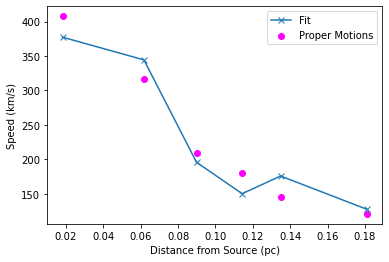

In [264]:
#plotting speed as a function of t, the travel time, and alpha

#observed proper motions, need to declare before the function
# vobs = np.array([407.63980695, 317.21726397, 227.49041226, 205.42416833, 195.30909916, \
#                  187.11332797, 172.77048953, 145.2505226, 122.81817916, 118.9748019])

vobs = np.array([407.63980695, 317.21726397, \
                 np.mean([227.49041226, 205.42416833, 195.30909916]), \
                 np.mean([187.11332797, 172.77048953]), \
                 145.2505226, \
                 np.mean([122.81817916, 118.97480194])])

#distances to help with fit
knot_source_dist = np.array([0.01820776, 0.06173051, \
                            np.mean([0.08657498, 0.08917799, 0.09389317,]), \
                           np.mean([0.11140937, 0.11715022, ]), \
                            0.13485113, \
                            np.mean([0.17794939, 0.18407689])])


def proper_motion_tester(knot_source_dist, incl, beta, Omega_p, vj, alpha):
    #finding times assuming vj ~ 480 km/s and v = d/t or t = d/v
    te = knot_source_dist / (vj * 1.022 )
    t = np.max(te)

    # compute velocities and positions
    # coordinate system xy orbital plane, z perpendicular to it
    #initial values
    vxarr_e = -r0*omega_B*np.cos(omega_B*te)+ vj*np.sin(beta)*np.cos(Omega_p*te - phi0)
    vyarr_e =  r0*omega_B*np.sin(omega_B*te)+ vj*np.sin(beta)*np.sin(Omega_p*te - phi0)
    vzarr_e =  vj*np.cos(beta)

    # instantaneous values for velocity 
    expfac = np.exp(-(t-te)*alpha)
    vxarr = vxarr_e*expfac
    vyarr = vyarr_e*expfac
    vzarr = vzarr_e*expfac

    # also rotate velocities 
    vxsarr = vxarr
    vysarr =  np.cos(incl)*vyarr + np.sin(incl)*vzarr
    vzsarr = -np.sin(incl)*vyarr + np.cos(incl)*vzarr
        
    return np.sqrt(vxsarr**2.+vzsarr**2.)

def speed_min(init_params, knot_source_dist):
    incl, beta, Omega_p, vj, alpha = init_params
    vtheory = proper_motion_tester(knot_source_dist, incl, beta, Omega_p, vj, alpha)
    return np.sqrt(np.sum((vobs - vtheory)**2.))

'''
wait can I just take the derivative of this stuff and set equal to 0 and solve...???
'''

#looping through parameter space of interest (te, alpha)
#variables that we are changing and testing
# Omega_p_fac = 15 # ratio of periods precession to orbital 
Omega_p = 149553.50585552122*200 # omega_B/Omega_p_fac  # units Myr-1, this is the precession rate 

#shape
incl = 0.5*1.57079633e+00 # np.pi/3.4  # inclination tilt of orbital z axis out of plane of sky in radians
phi0 = 3.57582550e+00 # np.pi/2  # initial precession phase in radians 
PA_deg = 1.54293570e+01 # 0.0 # position angle on sky to rotate from N, in degrees

beta_deg  = 17.0 # half opening angle for jet in degrees 
beta = 1.57139160e+00 #beta_deg*np.pi/180  # in radians, opening angle of jet

vj = 480 #trying to set this as a fixed parameter for now since it is difficult to change and very sensitive
alpha_list = [300] # how fast to slow velocity down, units Myr-1

bounds = ((0, np.pi/2), (0, np.pi/3), (0, 1e10), (400, 500), (0, 1e5))

for alpha in alpha_list:   
    #by minimize
    params_tomin = [incl, beta, Omega_p, vj, alpha]
    print(params_tomin)
    params_minfit = minimize(speed_min, params_tomin, args=(knot_source_dist), bounds=bounds) #BFGS, COBYLA, trust-constr
    print(params_minfit)
    v_theory_fit = proper_motion_tester(knot_source_dist, *params_minfit['x'])
    plt.plot(knot_source_dist, v_theory_fit, marker='x', label='Fit')

plt.scatter(knot_source_dist, vobs, color='fuchsia', label='Proper Motions')
plt.ylabel('Speed (km/s)')
plt.xlabel('Distance from Source (pc)')
plt.legend(loc='best')

# Past Attempts

Included trying to fit times, fit the shape and speeds separately, and got negative alphas...

[0.0003, 0.001, 0.0279133483, 0.0779045099]
      fun: 482.49875148790903
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.59440674, -44.24616122,   0.        ,  -0.18036417])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 75
      nit: 6
     njev: 15
   status: 0
  success: True
        x: array([0.00029265, 0.00098003, 0.02791335, 0.0815723 ])


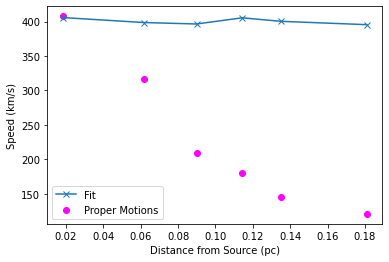

In [198]:
#plotting speed as a function of t, the travel time, and alpha

Omega_p_fac = 15 # ratio of periods precession to orbital 
Omega_p = 1.99032747e+03 # omega_B/Omega_p_fac  # units Myr-1, this is the precession rate 

#shape
incl = 1.57079633e+00 # np.pi/3.4  # inclination tilt of orbital z axis out of plane of sky in radians
phi0 = 3.57582550e+00 # np.pi/2  # initial precession phase in radians 
PA_deg = 1.54293570e+01 # 0.0 # position angle on sky to rotate from N, in degrees

beta_deg  = 17.0 # half opening angle for jet in degrees 
beta = 1.57139160e+00 #beta_deg*np.pi/180  # in radians, opening angle of jet


#observed proper motions, need to declare before the function
# vobs = np.array([407.63980695, 317.21726397, 227.49041226, 205.42416833, 195.30909916, \
#                  187.11332797, 172.77048953, 145.2505226, 122.81817916, 118.9748019])

vobs = np.array([407.63980695, 317.21726397, \
                 np.mean([227.49041226, 205.42416833, 195.30909916]), \
                 np.mean([187.11332797, 172.77048953]), \
                 145.2505226, \
                 np.mean([122.81817916, 118.97480194])])

vj = 4.00350342e+02 #trying to set this as a fixed parameter for now since it is difficult to change and very sensitive

def proper_motion_tester(knot_source_sep, tlower, tupper, tspacing, alpha):
    span = (tupper - tlower)
    steps = len(vobs)
    dx = 1.0 / (steps-1)
    te = np.array([tlower + (i*dx)**tspacing*span for i in range(steps)])
    t = np.max(te)

    # compute velocities and positions
    # coordinate system xy orbital plane, z perpendicular to it
    #initial values
    vxarr_e = -r0*omega_B*np.cos(omega_B*te)+ vj*np.sin(beta)*np.cos(Omega_p*te - phi0)
    vyarr_e =  r0*omega_B*np.sin(omega_B*te)+ vj*np.sin(beta)*np.sin(Omega_p*te - phi0)
    vzarr_e =  vj*np.cos(beta)

    # instantaneous values for velocity 
    expfac = np.exp(-(t-te)*alpha)
    vxarr = vxarr_e*expfac
    vyarr = vyarr_e*expfac
    vzarr = vzarr_e*expfac

    # also rotate velocities 
    vxsarr = vxarr
    vysarr =  np.cos(incl)*vyarr + np.sin(incl)*vzarr
    vzsarr = -np.sin(incl)*vyarr + np.cos(incl)*vzarr
        
    return np.sqrt(vxsarr**2.+vzsarr**2.)

def speed_min(init_params, knot_source_sep):
    tlower, tupper, tspacing, alpha = init_params
    vtheory = proper_motion_tester(knot_source_sep, tlower, tupper, tspacing, alpha)
    return np.sqrt(np.sum((vobs - vtheory)**2.))

'''
wait can't I just take the derivative of this stuff and set equal to 0 and solve...???
'''
#distances to help with fit
knot_source_dist = np.array([0.01820776, 0.06173051, \
                            np.mean([0.08657498, 0.08917799, 0.09389317,]), \
                           np.mean([0.11140937, 0.11715022, ]), \
                            0.13485113, \
                            np.mean([0.17794939, 0.18407689])])


#looping through parameter space of interest (te, alpha)
#variables that we are changing and testing
alpha_list = [7.79045099e-02] # how fast to slow velocity down, units Myr-1
tlower = 3e-4 #np.min(te) #3e-4
tupper = 1e-3 #np.max(te) #1e-3
tspacing = 2.79133483e-02

bounds = ((0, 1), (0, 1), (0, 1), (0, 10000))

for alpha in alpha_list:   
    #by curve fit
#     init_params = (tlower, tupper, tspacing, alpha)
#     popt, pcov = curve_fit(proper_motion_tester, knot_source_sep, vobs, p0=init_params)
#     print(popt)
#     tlower, tupper, tspacing, alpha = popt
#     v_theory = proper_motion_tester(knot_source_sep, tlower, tupper, tspacing, alpha)
#     plt.plot(knot_source_sep, v_theory, marker='x', label='alpha='+str(alpha))

    #by minimize
    params_tomin = [tlower, tupper, tspacing, alpha]
    print(params_tomin)
    params_minfit = minimize(speed_min, params_tomin, args=(knot_source_dist), tol=1e-10, \
                            bounds=bounds) #BFGS, COBYLA, trust-constr
    print(params_minfit)
    v_theory_fit = proper_motion_tester(knot_source_dist, *params_minfit['x'])
    plt.plot(knot_source_dist, v_theory_fit, marker='x', label='Fit')

plt.scatter(knot_source_dist, vobs, color='fuchsia', label='Proper Motions')
plt.ylabel('Speed (km/s)')
plt.xlabel('Distance from Source (pc)')
plt.legend(loc='best')

In [ ]:
#variables that I need to fix based on the last cell...
#trying initial guesses out by hand
# tlower = 1e-10
# tupper = 7.75272429e-04
# tspacing = 4.64533172e-20
# vj = 482
# alpha = 25
# init_params = (tlower, tupper, tspacing, alpha, vj)
# speed_min(init_params, knot_source_sep)

#for making list of times...from https://stackoverflow.com/questions/32504766/python-generate-unevenly-spaced-array
def my_lin(lb, ub, spacing):
    steps = len(vobs)
    span = (ub-lb)
    dx = 1.0 / (steps-1)
    return np.array([lb + (i*dx)**spacing*span for i in range(steps)])

tlower, tupper, tspacing, alpha = params_minfit['x']
te = my_lin(tlower, tupper, tspacing)
t = np.max(te)
print(alpha, te)

plt.plot(te*1e6, v_theory_fit, 'bx-')
plt.xlabel('Time (yr)')
plt.ylabel('Tangential Speed (km/s)')

In [ ]:
#initial parameters and setup

#observed shape on sky, needs to be setup before function...
ra_pc_list = np.array([0.40378838, 0.43791952, \
                np.mean([0.46161887, 0.46515381, 0.47080677]), \
                   np.mean([0.48958144, 0.49457684]), 
                    0.5166475 , 
                     np.mean([0.56515751, 0.57174669])
                      ])
#np.array(ra_pix_list) * hst_pixsize * 430.1 / 206265
dec_pc_list = np.array([0.19297749, 0.16577757, \
                np.mean([0.1565024 , 0.15732436, 0.15776662]), \
                   np.mean([0.15622932, 0.15334822]), 
                    0.16142637, 
                     np.mean([0.18417474, 0.18925407])
                       ])
# np.array(dec_pix_list) * hst_pixsize * 430.1 / 206265

def shape_pc_fit(vobs, incl, phi0, PA_deg, beta, Omega_p):
    
    # compute velocities and positions
    # coordinate system xy orbital plane, z perpendicular to it
    #initial values
    vxarr_e = -r0*omega_B*np.cos(omega_B*te)+ vj*np.sin(beta)*np.cos(Omega_p*te - phi0)
    vyarr_e =  r0*omega_B*np.sin(omega_B*te)+ vj*np.sin(beta)*np.sin(Omega_p*te - phi0)
    vzarr_e =  vj*np.cos(beta)

    # instantaneous values for velocity 
    expfac = np.exp(-(t-te)*alpha)
    vxarr = vxarr_e*expfac
    vyarr = vyarr_e*expfac
    vzarr = vzarr_e*expfac

    # also rotate velocities 
    vxsarr = vxarr
    vysarr =  np.cos(incl)*vyarr + np.sin(incl)*vzarr
    vzsarr = -np.sin(incl)*vyarr + np.cos(incl)*vzarr
    
    # integrated positions
    slow_fac = (1.  - np.exp(-(t-te)*alpha))/alpha
    xarr = vxarr_e*slow_fac + r0*np.cos(omega_B*te)
    yarr = vyarr_e*slow_fac + r0*np.sin(omega_B*te)
    zarr = vzarr_e*slow_fac

    # rotate x,y,z to xs,ys,zs
    xsarr = xarr
    ysarr =  np.cos(incl)*yarr + np.sin(incl)*zarr
    zsarr = -np.sin(incl)*yarr + np.cos(incl)*zarr

    # rotate by position angle on sky from N, converting to pixel coordinates
    PA = PA_deg*np.pi/180.

    xsarr_PA = np.cos(PA)*xsarr - np.sin(PA)*zsarr + ra_pc_list[-1]
    zsarr_PA = np.sin(PA)*xsarr + np.cos(PA)*zsarr + dec_pc_list[-1]
#     xsarr_PA = (np.cos(PA)*xsarr - np.sin(PA)*zsarr ) * 206265 / 430.1 / hst_pixsize 
#     zsarr_PA = (np.sin(PA)*xsarr + np.cos(PA)*zsarr ) * 206265 / 430.1 / hst_pixsize 

    return xsarr_PA, zsarr_PA
#     return np.sqrt(xsarr_PA**2. + zsarr_PA**2.)


def shape_min_tester(params_precess, vobs):
    xsarr_PA, zsarr_PA = shape_pc_fit(vobs, *params_precess)
    return np.sqrt(np.sum((xsarr_PA-ra_pc_list)**2 + (zsarr_PA-dec_pc_list)**2))
#     return (np.sum(np.sqrt(xsarr_PA**2.+zsarr_PA**2.**2) - np.sqrt(ra_pc_list**2. + dec_pc_list**2.)))**2 / 1e-22

#looping through parameter space of interest (te, alpha)
#applying minimization scheme
incl = 30 * np.pi/180 # inclination tilt of orbital z axis out of plane of sky in radians
phi0 = 200*np.pi/180  # initial precession phase in radians 
PA_deg = 120 # position angle on sky to rotate from N, in degrees
beta_deg  = 17 #17.0 # half opening angle for jet in degrees 
beta = beta_deg*np.pi/180  # in radians, opening angle of jet
# Omega_p_fac = 13 # ratio of periods precession to orbital 
Omega_p = 1000 # omega_B/Omega_p_fac  # units Myr-1, this is the precession rate 

#quicker checks to see if fit successful
#by minimizing
params_precess = [incl, phi0, PA_deg, beta, Omega_p] 
bounds = ((-np.pi/2, np.pi/2), (0, 2*np.pi), (0, 360), (0, 2*np.pi), (1, 1e6))
res = minimize(shape_min_tester, params_precess, args=(vobs), bounds=bounds)  #BFGS, COBYLA, trust-constr
print(res)
x, z = shape_pc_fit(vobs, *res['x'])
print(x, z)
plt.plot(x, z, 'ro--', label='Theoretical Shape')

plt.scatter(ra_pc_list, dec_pc_list, label='Observed Shape')
plt.xlabel('Detector X (pc)')
plt.ylabel('Detector Y (pc)')

#by curve fit...
# params_precess = (incl, phi0, PA_deg, beta, Omega_p)
# popt, pcov = curve_fit(shape_pc_fit, vobs, knot_source_sep, p0=params_precess)
# plt.plot(vobs, shape_pc_fit(vobs, *popt), label='Theoretical Shape')
# plt.plot(vobs, knot_source_sep, label='Observed Shape')
# plt.xlabel('Observed Knot Speed (km/s)')
# plt.ylabel('Distance (pc)')

#other formatting
plt.legend(loc='best')

# plotting on the sky...

In [ ]:
xsarr_PA/430.1*206265/hst_pixsize, zsarr_PA/430.1*206265/hst_pixsize

In [ ]:
#the data is offset from where it should be...
#maybe the issue depends on epoch used, using pc_list inputted by hand

ra0, dec0 = ra_pc_list[-1], dec_pc_list[-1]

#plotting to compare
fig, ax = plt.subplots(figsize=(15, 15))

#plotting theoretical fit
xsarr_PA, zsarr_PA = shape_pc_fit(vobs, *res['x'])
ax.plot((-xsarr_PA+ra0*1.15)/430.1*206265/hst_pixsize, (zsarr_PA-dec0/3)/430.1*206265/hst_pixsize, 'o--', color='blue', label = 'Theoretical')

# ax.scatter(dec_pc_list, ra_pc_list, label='Observed')
ax.imshow(hdu_data_list[0], vmin=0, vmax=1e-17)
ax.scatter(ra_pc_list/430.1*206265/hst_pixsize, dec_pc_list/430.1*206265/hst_pixsize, color='cyan', label='Observed') 

ax.invert_xaxis() #done because it's nicer with ra decreasing
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='best')

# Redo to try to get more exact fits, simultaneous fitting

maybe need a simultaneous fit to both positions and velocities? or scipy.optimize.brute, emcee??

In [ ]:
#trying to find te for the knots...

vj = 750 #trying to set this as a fixed parameter for now since it is difficult to change and very sensitive

#some initial guesses...
incl = 320 * np.pi/180  # inclination tilt of orbital z axis out of plane of sky in radians
phi0 = 140 * np.pi/180  # initial precession phase in radians 
PA_deg = 30 # position angle on sky to rotate from N, in degrees
beta_deg  = 17.0 #17.0 # half opening angle for jet in degrees 
beta = beta_deg*np.pi/180  # in radians, opening angle of jet
Omega_p_fac = 100 # ratio of periods precession to orbital 
Omega_p = omega_B/Omega_p_fac  # units Myr-1, this is the precession rate 

def proper_motion_tester(knot_source_dist, tlower, tupper, alpha):
    te = np.linspace(tlower,tupper,6)  #in Myrs
    t = np.max(te) # current time is the maximum of possible ejection times

    # compute velocities and positions
    # coordinate system xy orbital plane, z perpendicular to it
    #initial values
    vxarr_e = -r0*omega_B*np.cos(omega_B*te)+ vj*np.sin(beta)*np.cos(Omega_p*te - phi0)
    vyarr_e =  r0*omega_B*np.sin(omega_B*te)+ vj*np.sin(beta)*np.sin(Omega_p*te - phi0)
    vzarr_e =  vj*np.cos(beta)

    # instantaneous values for velocity 
    expfac = np.exp(-(t-te)*alpha)
    vxarr = vxarr_e*expfac
    vyarr = vyarr_e*expfac
    vzarr = vzarr_e*expfac

    # also rotate velocities 
    vxsarr = vxarr
    vysarr =  np.cos(incl)*vyarr + np.sin(incl)*vzarr
    vzsarr = -np.sin(incl)*vyarr + np.cos(incl)*vzarr
    
        # integrated positions
    slow_fac = (1.  - np.exp(-(t-te)*alpha))/alpha
    xarr = vxarr_e*slow_fac + r0*np.cos(omega_B*te)
    yarr = vyarr_e*slow_fac + r0*np.sin(omega_B*te)
    zarr = vzarr_e*slow_fac

    # rotate x,y,z to xs,ys,zs
    xsarr = xarr
    ysarr =  np.cos(incl)*yarr + np.sin(incl)*zarr
    zsarr = -np.sin(incl)*yarr + np.cos(incl)*zarr

    # rotate by position angle on sky from N, converting to pixel coordinates
    PA = PA_deg*np.pi/180.

    xsarr_PA = np.cos(PA)*xsarr - np.sin(PA)*zsarr # ra_pc_list[0]
    zsarr_PA = np.sin(PA)*xsarr + np.cos(PA)*zsarr # dec_pc_list[0]
#     xsarr_PA = (np.cos(PA)*xsarr - np.sin(PA)*zsarr ) * 206265 / 430.1 / hst_pixsize 
#     zsarr_PA = (np.sin(PA)*xsarr + np.cos(PA)*zsarr ) * 206265 / 430.1 / hst_pixsize 

    return np.sqrt(vxsarr**2.+vzsarr**2.), np.sqrt(xsarr_PA**2. + zsarr_PA**2.)

#looping through parameter space of interest (te, alpha)
#variables that we are changing and testing
alpha_list = [1800, 2000, 2200] # how fast to slow velocity down, units Myr-1
tlower = 0
tupper = 1e-3
# tspacing = 7.79133483e-02

for alpha in alpha_list:   
    #by hand
    mkarrs_slow_params = [m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha]
#     xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = proper_motion_tester(vobs, *mkarrs_slow_params)
#     mkarrs_slow_params = [m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg]
#     xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = mkarrs(*mkarrs_slow_params)
#     d_theory = np.sqrt(xsarr**2 + zsarr**2)
#     v_theory = np.sqrt(vxsarr**2 + vzsarr**2)

    v_theory, d_theory = proper_motion_tester(knot_source_dist, tlower, tupper, alpha)
    plt.plot(d_theory, v_theory, label='Fit: ' + str(alpha))
    
plt.scatter(knot_source_dist, vobs, color='fuchsia', label='Proper Motions')
plt.ylabel('Speed (km/s)')
plt.xlabel('Distance from Source (pc)')
plt.legend(loc='best')

In [ ]:
#trying to find te for the knots...

vj = 450 #trying to set this as a fixed parameter for now since it is difficult to change and very sensitive

#some initial guesses...
incl = 10 * np.pi/180  # inclination tilt of orbital z axis out of plane of sky in radians
phi0 = 45 * np.pi/180  # initial precession phase in radians 
PA_deg = 60 # position angle on sky to rotate from N, in degrees
beta_deg  = 10.0 #17.0 # half opening angle for jet in degrees 
beta = beta_deg*np.pi/180  # in radians, opening angle of jet
Omega_p_fac = 30 # ratio of periods precession to orbital 
Omega_p = omega_B/Omega_p_fac  # units Myr-1, this is the precession rate 

def proper_motion_tester(knot_source_dist, tlower, tupper, alpha):
    te = 10**np.logspace(tlower,tupper,100000)  #in Myrs
    t = np.max(te) # current time is the maximum of possible ejection times

    # compute velocities and positions
    # coordinate system xy orbital plane, z perpendicular to it
    #initial values
    vxarr_e = -r0*omega_B*np.cos(omega_B*te)+ vj*np.sin(beta)*np.cos(Omega_p*te - phi0)
    vyarr_e =  r0*omega_B*np.sin(omega_B*te)+ vj*np.sin(beta)*np.sin(Omega_p*te - phi0)
    vzarr_e =  vj*np.cos(beta)

    # instantaneous values for velocity 
    expfac = np.exp(-(t-te)*alpha)
    vxarr = vxarr_e*expfac
    vyarr = vyarr_e*expfac
    vzarr = vzarr_e*expfac

    # also rotate velocities 
    vxsarr = vxarr
    vysarr =  np.cos(incl)*vyarr + np.sin(incl)*vzarr
    vzsarr = -np.sin(incl)*vyarr + np.cos(incl)*vzarr
    
        # integrated positions
    slow_fac = (1.  - np.exp(-(t-te)*alpha))/alpha
    xarr = vxarr_e*slow_fac + r0*np.cos(omega_B*te)
    yarr = vyarr_e*slow_fac + r0*np.sin(omega_B*te)
    zarr = vzarr_e*slow_fac

    # rotate x,y,z to xs,ys,zs
    xsarr = xarr
    ysarr =  np.cos(incl)*yarr + np.sin(incl)*zarr
    zsarr = -np.sin(incl)*yarr + np.cos(incl)*zarr

    # rotate by position angle on sky from N, converting to pixel coordinates
    PA = PA_deg*np.pi/180.

    xsarr_PA = np.cos(PA)*xsarr - np.sin(PA)*zsarr # ra_pc_list[0]
    zsarr_PA = np.sin(PA)*xsarr + np.cos(PA)*zsarr # dec_pc_list[0]
#     xsarr_PA = (np.cos(PA)*xsarr - np.sin(PA)*zsarr ) * 206265 / 430.1 / hst_pixsize 
#     zsarr_PA = (np.sin(PA)*xsarr + np.cos(PA)*zsarr ) * 206265 / 430.1 / hst_pixsize 

    return np.sqrt(vxsarr**2.+vzsarr**2.), np.sqrt(xsarr_PA**2. + zsarr_PA**2.)

#looping through parameter space of interest (te, alpha)
#variables that we are changing and testing
alpha_list = [1000,2000,2200] # how fast to slow velocity down, units Myr-1
tlower = 0
tupper = np.log10(3e-5)
# tspacing = 7.79133483e-02

for alpha in alpha_list:   
    #by hand
    mkarrs_slow_params = [m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha]
#     xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = proper_motion_tester(vobs, *mkarrs_slow_params)
#     mkarrs_slow_params = [m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg]
#     xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = mkarrs(*mkarrs_slow_params)
#     d_theory = np.sqrt(xsarr**2 + zsarr**2)
#     v_theory = np.sqrt(vxsarr**2 + vzsarr**2)

    v_theory, d_theory = proper_motion_tester(knot_source_dist, tlower, tupper, alpha)
    plt.plot(d_theory, v_theory, label='Fit: ' + str(alpha))
    
plt.scatter(knot_source_dist, vobs, color='fuchsia', label='Proper Motions')
plt.ylabel('Speed (km/s)')
plt.xlabel('Distance from Source (pc)')
plt.legend(loc='best')

In [ ]:
vj = 430 #trying to set this as a fixed parameter for now since it is difficult to change and very sensitive

incl = 320 * np.pi/180  # inclination tilt of orbital z axis out of plane of sky in radians
phi0 = 140 * np.pi/180  # initial precession phase in radians 
PA_deg = 30 # position angle on sky to rotate from N, in degrees
beta_deg  = 17.0 #17.0 # half opening angle for jet in degrees 
beta = beta_deg*np.pi/180  # in radians, opening angle of jet
Omega_p_fac = 100 # ratio of periods precession to orbital 
Omega_p = omega_B/Omega_p_fac  # units Myr-1, this is the precession rate 

alpha_list = np.array([-10, -20]) * np.pi/180

for beta in alpha_list:   
    #by hand
    mkarrs_slow_params = [m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha]
#     xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = proper_motion_tester(vobs, *mkarrs_slow_params)
#     mkarrs_slow_params = [m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg]
#     xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = mkarrs(*mkarrs_slow_params)
#     d_theory = np.sqrt(xsarr**2 + zsarr**2)
#     v_theory = np.sqrt(vxsarr**2 + vzsarr**2)

    v_theory, d_theory = proper_motion_tester(knot_source_dist, tlower, tupper, 200)
    plt.plot(d_theory, v_theory, label='Fit: ' + str(beta))
    
plt.scatter(knot_source_dist, vobs, color='fuchsia', label='Proper Motions')
plt.ylabel('Speed (km/s)')
plt.xlabel('Distance from Source (pc)')
plt.legend(loc='best')

In [ ]:



def min_mkarrs_slow(mkarrs_slow_params, vobs):
    xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = mkarrs_slow(vobs, *mkarrs_slow_params)
    return np.sqrt(np.sum((xsarr_PA-ra_pc_list)**2 + (zsarr_PA-dec_pc_list)**2) + (vobs - vtheory)**2.)

#applying model fit
mkarrs_slow_params = [m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha]
res = minimize(min_mkarrs_slow, mkarrs_slow_params, args=(vobs))  #BFGS, COBYLA, trust-constr
xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = mkarrs_slow(vobs, *res['x'])
d_theory = np.sqrt(xsarr_PA**2 + zsarr_PA**2)
v_theory = np.sqrt(vxsarr**2 + vzsarr**2)
# plt.plot(knot_source_sep, v_theory_fit, marker='x', label='Fit')

plt.scatter(knot_source_sep, vobs, color='green', label='Proper Motions')
plt.ylabel('Speed (km/s)')
plt.xlabel('Distance from Source (pc)')
plt.legend(loc='best')

# Creating nicer figures, more finalized fits

In [ ]:
#modeling and parameters

#initial parameters and setup
m1 =  1.0 # masses msol, jet source
m2 =  1.0 #  companion mass msol
a_B_AU = 15.0  # AU

a_B=  a_B_AU*AUtopc #binary semi-major axis, convert from AU to pc
r0 = m2/(m1+m2) * a_B  # in pc - distance of m1 from Center of mass of binary
# units pc
# velocity of binary 
v_B = np.sqrt(G*(m1+m2)/a_B)  # velocity of binary orbit in km/s which is pc/Myr
# note: this is not w.r.t center of mass 
omega_B = v_B/a_B  # is in Myr-1, angular rotation rate of binary (mean motion)
# note that r0*omega_B < v_B
Omega_p_fac = 20 # ratio of periods precession to orbital 
Omega_p = omega_B/Omega_p_fac  # units Myr-1, this is the precession rate 

#shape
incl = np.pi/3  # inclination tilt of orbital z axis out of plane of sky in radians
phi0 = np.pi/2  # initial precession phase in radians 
PA_deg = 0.0 # position angle on sky to rotate from N, in degrees

beta_deg  = 17.0 # half opening angle for jet in degrees 
beta = beta_deg*np.pi/180  # in radians, opening angle of jet

vobs = np.array([407.63980695, 317.21726397, \
                 np.mean([227.49041226, 205.42416833, 195.30909916]), \
                 np.mean([187.11332797, 172.77048953]), \
                 145.2505226, \
                 np.mean([122.81817916, 118.97480194])])

vj = 484 #trying to set this as a fixed parameter for now since it is difficult to change and very sensitive

tlower = 2.88605099e-05
tupper = 2.07964893e-03
tspacing = 7.67400174e-02
span = (tupper - tlower)
steps = len(vobs)
dx = 1.0 / (steps-1)
te = np.array([tlower + (i*dx)**tspacing*span for i in range(steps)])
t = np.max(te)

alpha = -6.45775658e+01 # how fast to slow velocity down, units Myr-1

#applying model fit
xsarr,ysarr,zsarr,vxsarr,vysarr,vzsarr,xsarr_PA,zsarr_PA = mkarrs_slow(vobs, m1,m2,a_B_AU,beta_deg,phi0,incl,Omega_p_fac,te,t,PA_deg,alpha)
d_theory = np.sqrt(xsarr_PA**2 + zsarr_PA**2)
v_theory = np.sqrt(vxsarr**2 + vzsarr**2)


#plotting
fig, ax = plt.subplots(2,1, figsize=(10, 10))

#plotting speed data
shock_avgspeed_list = [65.18759970979076, 54.51555268406941, 
                       np.mean([61.481507371172526, 57.44686840157263, 50.89446450539283]), 
                       np.mean([57.80997894504378, 71.70453223950052]), 
                       35.93179768591641, 
                       np.mean([61.106088304897945, 58.75809943437806]) ]

df_cc_tanspeeds = np.array([342.45220724, 262.70171128, 
                            np.mean([166.00890489, 147.97729993, 144.41463466]), 
                            np.mean([129.30334903, 101.06595729]), 
                            109.31872491, 
                            np.mean([61.71209086,  60.2167025]) ])

ax[0].errorbar(knot_source_dist, shock_avgspeed_list, color='black', marker='x', label='Shocked Gas', linestyle='', linewidth=0.8)
ax[0].errorbar(knot_source_dist, df_cc_tanspeeds, yerr=22, color='goldenrod', marker='^', label='Tangential (Proper) Motion', linestyle='', linewidth=0.8)
ax[0].errorbar(knot_source_dist, vobs, yerr=22, color='forestgreen', marker='o', label='Bulk Outflow and Jet', linestyle='', linewidth=0.8)

# plotting the confidence intervals and fit
ax[0].plot(knot_source_dist, v_theory, 'k-', label='Precession Model') #fit
# bound_upper = exp_decay(dist_interp, *(params + sigma_p))
# bound_lower = exp_decay(dist_interp, *(params - sigma_p))
# ax[0].fill_between(dist_interp, bound_lower, bound_upper, color = 'black', alpha = 0.15)
ax2 = ax[0].twiny()
ax2.plot(te*1e6, v_theory, linestyle='')
ax2.set_xlabel('Age (yr)', fontsize=15)
ax2.tick_params(axis='x', labelsize=15)

ax[0].set_ylim(0, 450) #formatting
ax[0].set_ylabel('Speed (km/s)', fontsize=15)
ax[0].get_xaxis().set_visible(False)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].legend(loc='best', fontsize=15)

#plotting angular, unsure on fit
theta_list = np.array([32.52624266, 26.87287695, 20.02481018, 43.07241927, 45.40564179, 61.31892256, \
                35.37643808, -7.49445746, 84.47636084, 32.31030455])
theta_uncert_list = np.array([-2.6121514113367894, -3.025474463297236, -3.9419344706276647, -6.701540597329242, \
                     -7.054155324163659, -9.070700234925994, -8.410048867414027, -1.2604157573170198, \
                     -20.578687117238772, -12.19144769466596])
knot_source_pa = np.array([14.31128073, 8.76054827, 13.08573056, 14.73487355, 16.70694884, 20.59027569, \
                     20.3167963, 27.36926166, 39.16356146, 40.94520315])

knot_source_sep = np.array([0.01820776, 0.06173051, 0.08657498, 0.08917799, 0.09389317, \
       0.11140937, 0.11715022, 0.13485113, 0.17794939, 0.18407689])

ax[1].errorbar(knot_source_sep[0:2], theta_list[0:2], color='goldenrod', yerr=theta_uncert_list[0:2], linestyle='', linewidth=0.8, marker='o', label = 'Tangential Motion')
ax[1].errorbar(np.mean(knot_source_sep[3:5]), np.mean(theta_list[3:5]), color='goldenrod', yerr=np.mean(theta_uncert_list[3:5]), linestyle='', linewidth=0.8, marker='o')
ax[1].errorbar(np.mean(knot_source_sep[5:7]), np.mean(theta_list[5:7]), color='goldenrod', yerr=np.mean(theta_uncert_list[5:7]), linestyle='', linewidth=0.8, marker='o')
ax[1].errorbar(knot_source_sep[7], np.mean(theta_list[7]), color='goldenrod', yerr=theta_uncert_list[7], linestyle='', linewidth=0.8, marker='o')
ax[1].errorbar(np.mean(knot_source_sep[8:11]), np.mean(theta_list[8:11]), color='goldenrod', yerr=np.mean(theta_uncert_list[8:11]), linestyle='', linewidth=0.8, marker='o')

ax[1].scatter(knot_source_sep, theta_list-knot_source_pa, color='black')
ax[1].plot(knot_source_dist, [np.mean(theta_list-knot_source_pa)] * len(knot_source_dist), color='black', linestyle='--', label='Mean Difference')
ax[1].plot(knot_source_sep, knot_source_pa, color = 'blue', marker='s', label='Ballistic Assumption')
# ax[1].errorbar(knot_source_sep, theta_list, yerr=np.abs(theta_uncert_list), color='goldenrod', label='Tangential Motion', linestyle='', marker='^')

ax[1].set_ylabel('Position Angle (Degrees)', fontsize=15)
ax[1].tick_params(axis='y', labelsize=15)

#formatting x-axis
ax[1].set_xlabel('Knot-Protostar Separation (pc)', fontsize=15)
ax[1].tick_params(axis='x', labelsize=15)
plt.subplots_adjust(hspace=0.05)
ax[1].legend(loc='best', fontsize=15)

plt.savefig('speed_dist_trends.png', dpi=300, bbox_inches="tight")
plt.savefig('speed_dist_trends.pdf', dpi=300, bbox_inches="tight")

In [ ]:
Omega_p